In [35]:
!pip install finance-datareader

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
import FinanceDataReader as fdr

### Generate Dataset

In [ ]:
train_start_date = '2020-06-11'
train_end_date = '2023-03-23'

test_start_date = '2023-04-01'
test_end_date = '2023-07-01'

df_train = fdr.DataReader('005930', start=train_start_date, end=train_end_date)
df_test = fdr.DataReader('005930', start=test_start_date, end=test_end_date)

# 'Open', 'High', 'Low', 'Close'만 사용
df_train = df_train[['Open', 'High', 'Low', 'Close']]
df_test = df_test[['Open', 'High', 'Low', 'Close']]

In [ ]:
df_train.head(3)

,Open,High,Low,Close
Date,,,,
2020-06-11,54500,55100,53200,54300
2020-06-12,52100,52800,51500,52300
2020-06-15,51400,52000,49900,49900


<Axes: xlabel='Date'>

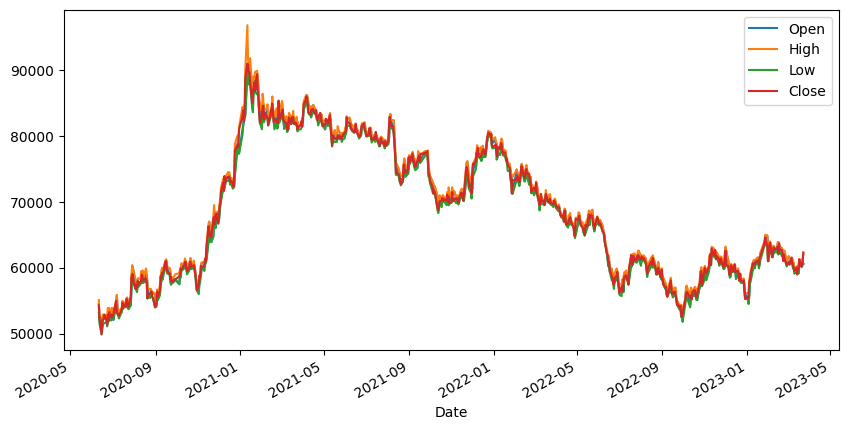

In [ ]:
df_train.plot(figsize=(10,5))

In [ ]:
scaler = MinMaxScaler()
scaler.fit(df_train)
train_scaled = scaler.transform(df_train)
test_scaled = scaler.transform(df_test)

In [ ]:
def make_sequence_data(data, seq_length):
    X = []
    y = []
    for i in range(len(data)-seq_length):
        try:
            X.append(data[i: i+seq_length, :])
            y.append(data[i+seq_length, 3])
        except:
            pass
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
seq_length = 4
X_train, y_train = make_sequence_data(train_scaled, seq_length)
X_test, y_test = make_sequence_data(test_scaled, seq_length)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ',y_train.shape)
print('X_test.shape = ',X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (685, 4, 4)
y_train.shape =  (685, 1)
X_test.shape =  (57, 4, 4)
y_test.shape =  (57, 1)


In [ ]:
# 데이터가 684개이므로 배치 사이즈를 684로 해서 1epoch에 전체 데이터를 다 학습해보자
# 현재 X_train은 (Batch_size, sequence length, input_dim) 인데 (seq_length, Batch_size, input_dim)으로 바꾸어 줘야한다.
X_train = np.swapaxes(X_train, 0, 1)
X_train.shape

#확인
# check = []
# for data in test:
#     check.append(data[0])
# print(check)
# print(X_train[0])

(4, 685, 4)

In [ ]:
for sequence, batch_data in enumerate(X_train):
    print(f"sequence: {sequence+1}, batch_data: {batch_data.shape}")

sequence: 1, batch_data: (685, 4)
sequence: 2, batch_data: (685, 4)
sequence: 3, batch_data: (685, 4)
sequence: 4, batch_data: (685, 4)


### RNN Pytorch Scratch

In [36]:
class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size):
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size

        # nn.Linear는 선형 변환을 의미한다.즉, (output_dim, input_dim)의 matrix를 만드는것과 동일
        self.w_x = nn.Linear(self.input_dim,  self.hid_dim, bias=False)
        self.w_h = nn.Linear(self.hid_dim,  self.hid_dim, bias=False)
        self.w_y = nn.Linear(self.hid_dim, self.output_dim, bias=True)
        self.activation = nn.Tanh()

        self.hidden = self.init_hidden() #hidden은 연산을 위해 필요할뿐 결국 모델은(w_x, w_h, w_y)

    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)

    def forward(self, x):
        h = self.activation(self.w_x(x) + self.w_h(self.hidden))
        y = self.w_y(h)
        return y, h

In [39]:
model = RNN(4, 1, 10, 685)
model

RNN(
  (w_x): Linear(in_features=4, out_features=10, bias=False)
  (w_h): Linear(in_features=10, out_features=10, bias=False)
  (w_y): Linear(in_features=10, out_features=1, bias=True)
  (activation): Tanh()
)

### model train

In [40]:
loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)
epoch = 100

for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    model.hidden = model.init_hidden()

    for x in X_train:
        x = torch.Tensor(x).float()
        y_train = torch.Tensor(y_train).float()

        y_pred, hidden = model(x)
        model.hidden = hidden
    loss = loss_fn(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if i%10==0:
        print(f"EPOCH: {i} Loss:{loss.item()}")

EPOCH: 0 Loss:0.25322026014328003
EPOCH: 10 Loss:0.15589028596878052
EPOCH: 20 Loss:0.09896555542945862
EPOCH: 30 Loss:0.06511391699314117
EPOCH: 40 Loss:0.04479488357901573
EPOCH: 50 Loss:0.03251342847943306
EPOCH: 60 Loss:0.025031739845871925
EPOCH: 70 Loss:0.020422210916876793
EPOCH: 80 Loss:0.017532721161842346
EPOCH: 90 Loss:0.015674179419875145


In [41]:
X_test = np.swapaxes(X_test, 0, 1)
X_test.shape

(4, 57, 4)

In [43]:
list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=57)

    for x in X_test:
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred)

Text(0, 0.5, 'Stock price(close)')

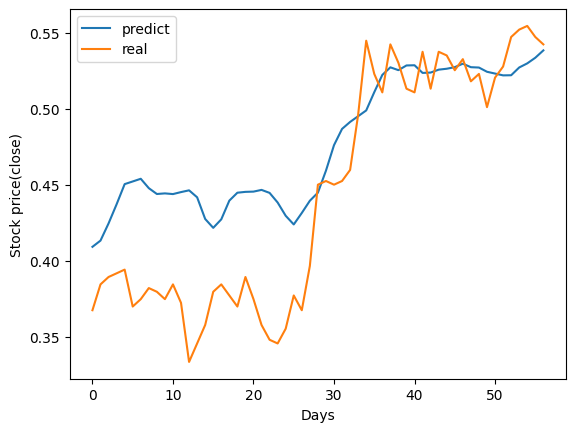

In [46]:
import matplotlib.pyplot as plt

plt.plot(np.array(list_y_pred[0]), label='predict')
plt.plot(np.array(y_test), label='real')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Stock price(close)")